In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

In [2]:
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

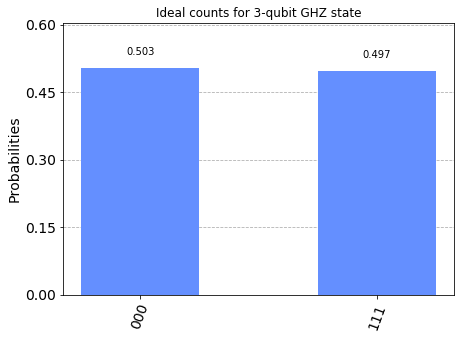

In [3]:
# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

sim_ideal = AerSimulator()

# Execute and get counts
result = sim_ideal.run(transpile(circ, sim_ideal)).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

In [4]:
sim_vigo = AerSimulator.from_backend(device_backend)

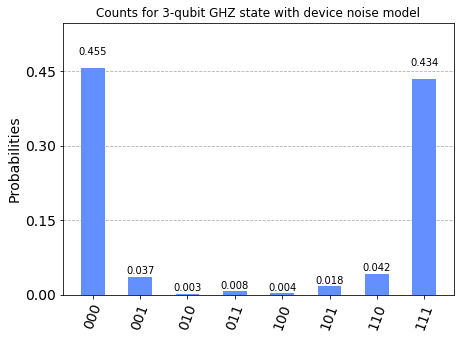

In [5]:
# Transpile the circuit for the noisy basis gates
tcirc = transpile(circ, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts()
plot_histogram(counts_noise,
               title="Counts for 3-qubit GHZ state with device noise model")

Costom Noise Model

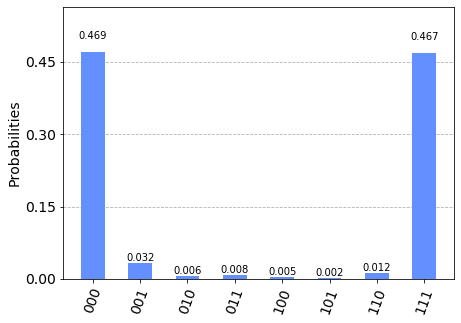

In [6]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import qiskit.providers.aer.noise as noise

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.05   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Make a circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

# Perform a noise simulation
result = execute(circ, Aer.get_backend('qasm_simulator'),
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
counts = result.get_counts()
plot_histogram(counts)

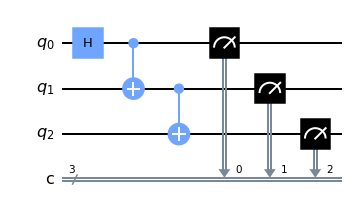

In [7]:
circ.draw(output='mpl')

 Rydberg Blockade (Open Boundary) via Trotter Circuit, no Noise Model

In [8]:
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits
    


In [9]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 5 # Total time

TT=T

n = 20

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

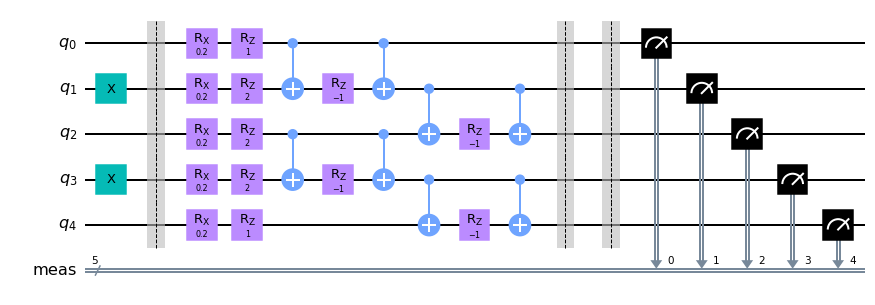

In [10]:
Trotter_circuit[1].draw(output='mpl')

In [11]:
shots = 8192

il = [0,1,2,3,4]

#result = execute(circ, Aer.get_backend('qasm_simulator'),
#                 basis_gates=basis_gates,
#                 noise_model=noise_model).result()

Trotter_circuit_sim = execute(Trotter_circuit, Aer.get_backend('qasm_simulator')
                              , shots=shots, initial_layout=il)

#Trotter_result = execute(Trotter_circuit, backend, shots=shots, initial_layout=il)

#Trotter_mit  = execute(meas_calibs, backend, shots=shots, initial_layout=il)

In [12]:
result_sim=Trotter_circuit_sim.result()

Sz_sim = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim = result_sim.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim.int_outcomes()[j] 
    Sz_sim.append(tot_sim/shots)
Sz_sim=np.array(Sz_sim)

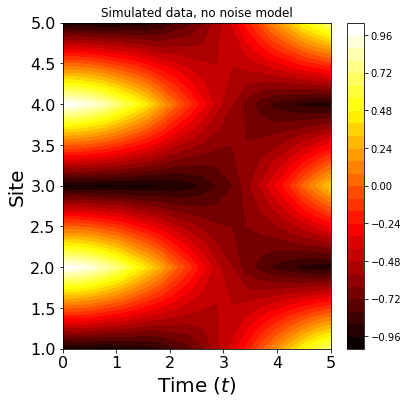

In [13]:
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Simulated data, no noise model')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

Same Model, with Noise Modeling

In [14]:
sim_vigo = AerSimulator.from_backend(device_backend)

In [15]:
shots = 8192

il = [0,1,2,3,4]

Trotter_circuit_sim = execute(Trotter_circuit, Aer.get_backend('qasm_simulator'), basis_gates=basis_gates,
                              noise_model = noise_model, shots=shots, initial_layout=il)

In [16]:
# Transpile the circuit for the noisy basis gates
tcirc = transpile(Trotter_circuit, sim_vigo)

In [17]:
result_sim_noise=Trotter_circuit_sim.result()

Sz_sim_noise = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim_noise = result_sim_noise.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim_noise.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim_noise.int_outcomes()[j] 
    Sz_sim_noise.append(tot_sim/shots)
Sz_sim_noise=np.array(Sz_sim_noise)

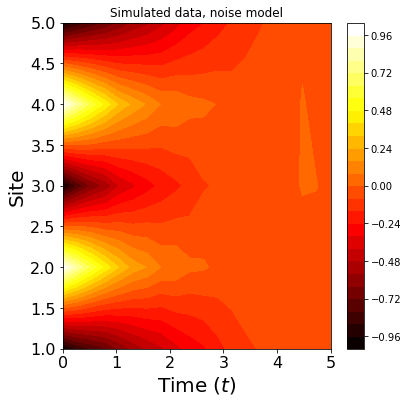

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim_noise), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Simulated data, noise model')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

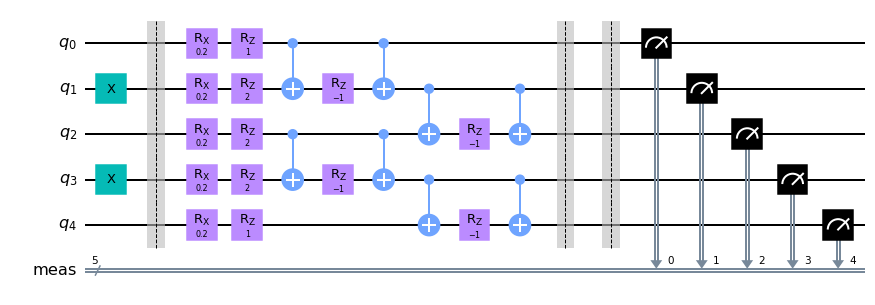

In [19]:
Trotter_circuit[1].draw(output='mpl')

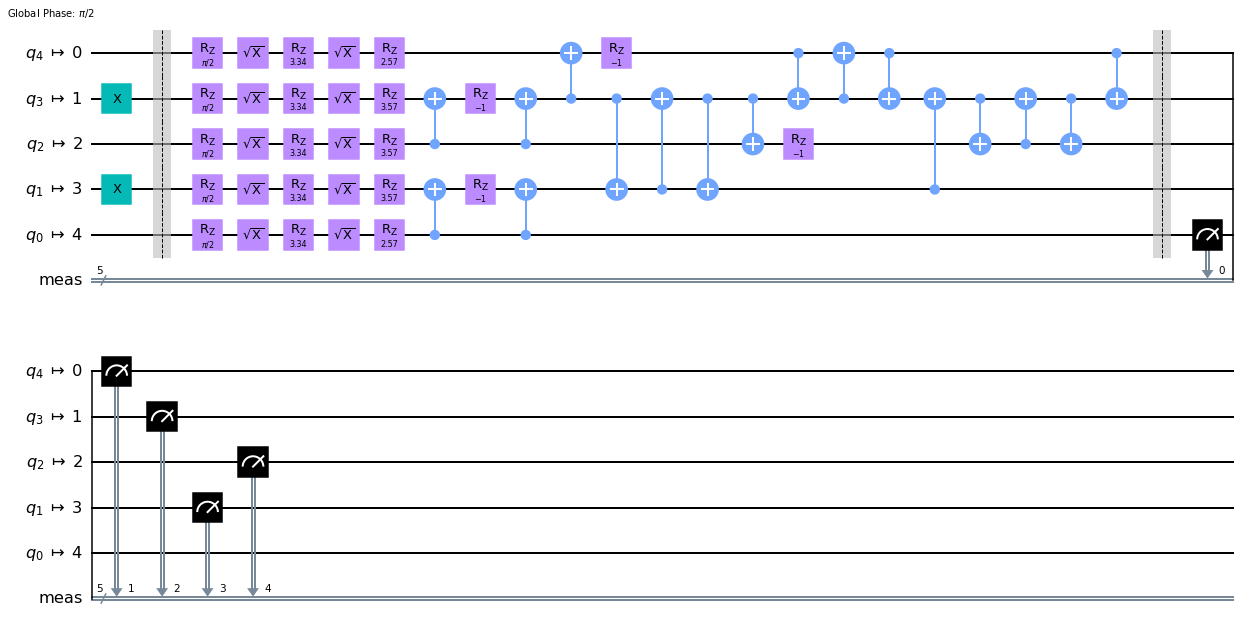

In [20]:
tcirc[1].draw(output='mpl')

In [21]:
q0_mit_list = []
q1_mit_list = []
q2_mit_list = []
q3_mit_list = []
q4_mit_list = []

for x in range(0,len(Sz_sim_noise)):
    q0_mit_list.append(Sz_sim_noise[x,0])
    q1_mit_list.append(Sz_sim_noise[x,1])
    q2_mit_list.append(Sz_sim_noise[x,2])
    q3_mit_list.append(Sz_sim_noise[x,3])
    q4_mit_list.append(Sz_sim_noise[x,4])

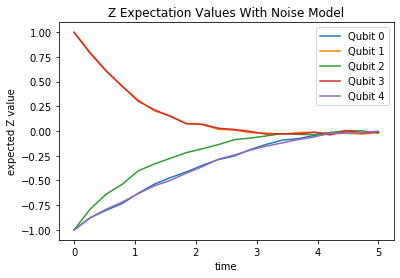

In [22]:
fig,ax = plt.subplots()
ax.plot(t, q0_mit_list, label='Qubit 0')
ax.plot(t, q1_mit_list, label='Qubit 1')
ax.plot(t, q2_mit_list, label='Qubit 2')
ax.plot(t, q3_mit_list, label='Qubit 3')
ax.plot(t, q4_mit_list, label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Z Expectation Values With Noise Model")
ax.legend()

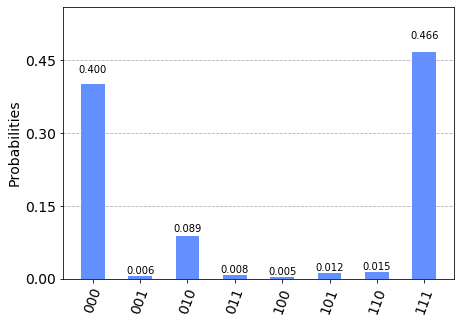

In [23]:
from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_santiago')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Make a circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

# Perform a noise simulation
result = execute(circ, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
counts = result.get_counts(0)
plot_histogram(counts)